In [ ]:
# Importing Libraries
import tweepy
import csv
import time
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from textblob import TextBlob
import matplotlib.pyplot as plt

# Importing Scikit-learn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, auc
)

# Importing Other Libraries
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Basic libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

c:\Users\udits\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\udits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\udits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\udits\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\udits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Data cleaned and saved to cleaned_tweets_1.csv
                         Datetime  Tweet Id  \
0  Wed Jan 01 03:59:03 +0000 2014       NaN   
1  Wed Jan 01 18:08:47 +0000 2014       NaN   
2  Wed Jan 01 01:52:31 +0000 2014       NaN   
3  Wed Jan 01 10:52:20 +0000 2014       NaN   
4  Wed Jan 01 15:01:12 +0000 2014       NaN   

                                                Text    Username Company  \
0  rt AT_USER summary of yesterday's webcast feat...  1938270918    AAPL   
1              itv will boost apple URL $ aapl apple    23059499    AAPL   
2  iphone users are more intelligent than samsung...    23954327    AAPL   
3  2013 wrap-up and trading set review - part iii...    23059499    AAPL   
4        apple screwed up big time URL $ amzn $ aapl    23669783    AAPL   

         Date                                       cleaned_text  \
0  2014-01-01  rt atuser summary of yesterdays webcast featur...   
1  2014-01-01               itv will boost apple url  aapl apple   
2  2014-0

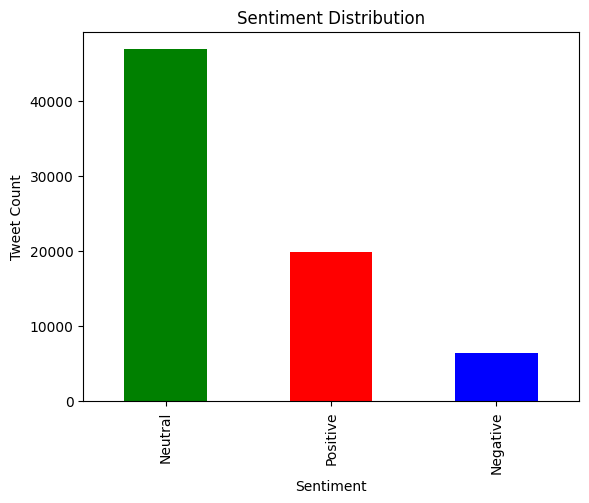

,Date,Company,average_sentiment
0,2014-01-01,AAPL,0.160000
1,2014-01-01,BAC,0.225000
2,2014-01-01,C,0.200000
3,2014-01-01,CAT,0.000000
4,2014-01-01,CSCO,0.411111
...,...,...,...
22785,2015-12-31,MSFT,0.000000
22786,2015-12-31,ORCL,0.000000
22787,2015-12-31,T,0.066667
22788,2015-12-31,UNH,0.000000


In [3]:
df_1 = pd.read_csv("stocknet_tweets_all_companies.csv")

# Remove duplicates
df_1 = df_1.drop_duplicates(subset="Text", keep="first")

# Handle missing data
df_1 = df_1.dropna(subset=["Text"])

# Define a function to clean the text
def clean_text(text):
    # Remove links, mentions, hashtags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()  # Convert to lowercase
    return text

# Clean the text
df_1["cleaned_text"] = df_1["Text"].apply(clean_text)

# Tokenize and remove stopwords
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df_1["processed_text"] = df_1["cleaned_text"].apply(preprocess_text)

# Optional: Filter out non-English tweets
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

# df_1 = df_1[df_1["processed_text"].apply(is_english)]

# Save the processed data
df_1.to_csv("cleaned_tweets_1.csv", index=False)
print("Data cleaned and saved to cleaned_tweets_1.csv")

# Load the cleaned data
df_1 = pd.read_csv("cleaned_tweets_1.csv")
print(df_1.head())
# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity


df_1['processed_text'] = df_1['processed_text'].fillna('')
# Add sentiment polarity to the DataFrame
df_1["sentiment"] = df_1["processed_text"].apply(get_sentiment)

# Categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df_1["sentiment_category"] = df_1["sentiment"].apply(categorize_sentiment)

# Save sentiment results
df_1.to_csv("tweets_with_sentiment_1.csv", index=False)

# Visualize sentiment distribution
sentiment_counts = df_1["sentiment_category"].value_counts()
sentiment_counts.plot(kind="bar", color=["green", "red", "blue"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

df_1.head(10)

# Group by 'Date' and 'Company', then calculate the average sentiment
average_sentiment_df = df_1.groupby(['Date', 'Company'])['sentiment'].mean().reset_index()

# Rename the sentiment column
average_sentiment_df.rename(columns={'sentiment': 'average_sentiment'}, inplace=True)
average_sentiment_df

In [ ]:
def train_model(stock):

    # Importing Libraries
    import tweepy
    import csv
    import time
    import pandas as pd
    import re
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from langdetect import detect
    from textblob import TextBlob
    import matplotlib.pyplot as plt

    # Importing Scikit-learn Libraries
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
    from sklearn.decomposition import LatentDirichletAllocation
    from wordcloud import WordCloud
    from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, VotingClassifier
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        f1_score, classification_report, roc_curve, auc
    )

    # Importing Other Libraries
    import numpy as np
    import shap
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.data import DataLoader, TensorDataset

    # Basic libraries
    import numpy as np
    import pandas as pd
    import warnings
    warnings.filterwarnings("ignore")

    # For processing
    import math
    import random
    import datetime as dt
    import matplotlib.dates as mdates

    # For visualization
    import matplotlib.pyplot as plt
    from mplfinance.original_flavor import candlestick_ohlc

    # Libraries for model training
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    from sklearn.metrics import mean_squared_error

    np.random.seed(42)
    # tf.random.set_seed(42)
    random.seed(42)
      # Replace 'AAPL' with the desired company symbol
    company_name = stock

    # Filter the average_sentiment_df for the specific company
    company_df = average_sentiment_df[average_sentiment_df['Company'] == company_name].reset_index(drop=True)

    # Copy the DataFrame so original isn't modified
    company_df = company_df.copy()

    # Initialize fixed_sentiment column
    company_df['fixed_sentiment'] = 0.0

    # Set the first value same as average_sentiment
    company_df.loc[0, 'fixed_sentiment'] = company_df.loc[0, 'average_sentiment']
    # Iterate from the second row and compute the average with the previous fixed_sentiment
    for i in range(1, len(company_df)):
        prev_fixed = company_df.loc[i - 1, 'fixed_sentiment']
        current_avg = company_df.loc[i, 'average_sentiment']
        company_df.loc[i, 'fixed_sentiment'] = (prev_fixed + current_avg) / 2

    import yfinance as yf
    import pandas as pd

    # Define the stock ticker
    ticker = stock  # You can replace with any other ticker

    # Download last 200 days of data
    # stock_data = yf.download(ticker, period='200d')
    stock_data = yf.download(ticker, start='2014-01-01', end='2015-12-31')
    # print(stock_data)
    # Reset index to bring the Date into a column
    stock_data = stock_data.reset_index()

    # print(stock_data['Close'].values.flatten())
    print("***************************************")
    print(stock_data)
    print("***************************************")

    # Create the DataFrame with 'Date' and 'Close' columns
    stock_df = pd.DataFrame({
        'Date': stock_data['Date'].dt.date.values.flatten(),  # Ensure the Date is 1D by extracting just the date part
        'Closing_Price': stock_data['Close'].values.flatten()  # The Close price is already 1D
    })

    last_30_days_stock = stock_df.tail(30)

    # If you want the 'Closing_Price' as a list, you can extract that column:
    last_30_closing_prices = last_30_days_stock['Closing_Price'].tolist()

    full_dates = pd.date_range(start='2014-01-01', end='2015-12-31').date

    # Ensure Date columns are datetime
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    # Filter company_df for matching dates in stock_df
    stock_df = stock_df[stock_df['Date'].isin(company_df['Date'])]

    stock_df1 = pd.DataFrame({
        'Closing_Price': stock_df['Closing_Price'].values.flatten()
    })
    print("***********************************************************")
    print(stock_df1)
    print("***********************************************************")
    import numpy as np
    # Normalizing our data using MinMaxScaler
    new_df=stock_df1
    scaler = MinMaxScaler()
    scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

    # Split into training and testing sets
    train_size = int(len(scaled_data) * 0.8)  # 80% for training
    train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


    # Define the sequence length (number of past time steps)
    n_past = 10

    # Prepare sequences for LSTM
    X_train, y_train = [], []
    for i in range(n_past, len(train_data)):
        X_train.append(train_data[i - n_past:i, 0])
        y_train.append(train_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Similarly prepare sequences for the test set
    X_test, y_test = [], []
    for i in range(n_past, len(test_data)):
        X_test.append(test_data[i - n_past:i, 0])
        y_test.append(test_data[i, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reshape input data for LSTM([samples, time steps, features])
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    s_idx=10
    updated_X_train = np.zeros((X_train.shape[0], X_train.shape[1] + 1, 1))

    # Iterate over each row in X_train
    for i in range(X_train.shape[0]):
        # Copy the existing data into updated_X_train
        updated_X_train[i, :-1, :] = X_train[i]

        # Add the fixed_sentiment value from continuous_df to the last element of the row
        updated_X_train[i, -1, 0] = company_df['fixed_sentiment'].iloc[s_idx]
        s_idx+=1

    ##model
    # Initialize a sequential model
    model = Sequential()

    # First LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(updated_X_train.shape[1], 1)))
    model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

    # Second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer with 50 units
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    model.compile(loss='mean_squared_error',optimizer='adam')


    # Defining our callbacks
    checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
    # Defining our early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Training our lstm model
    model.fit(updated_X_train, y_train,
              validation_data=(X_test,y_test),
              epochs=100,
              batch_size=32,
              verbose=1,
              callbacks= [checkpoints, early_stopping])


    # Create a new array to hold the updated X_train (150, 11, 1)
    updated_X_test = np.zeros((X_test.shape[0], X_test.shape[1] + 1, 1))

    # Iterate over each row in X_train
    for i in range(X_test.shape[0]):
        # Copy the existing data into updated_X_train
        updated_X_test[i, :-1, :] = X_test[i]

        # Add the fixed_sentiment value from continuous_df to the last element of the row
        updated_X_test[i, -1, 0] = company_df['fixed_sentiment'].iloc[s_idx]
        s_idx+=1

    # Let's do the prediction and check performance metrics
    train_predict=model.predict(updated_X_train)
    test_predict=model.predict(updated_X_test)

    import math
    # Calculate train data RMSE
    print(math.sqrt(mean_squared_error(y_train,train_predict)))
    # Calculate test data RMSE
    print(math.sqrt(mean_squared_error(y_test,test_predict)))
    print(math.sqrt(mean_squared_error(y_train,train_predict))/np.mean(y_train))
    print(math.sqrt(mean_squared_error(y_test,test_predict))/np.mean(y_test))

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np
    import math

    # RMSE
    train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))

    # NRMSE
    train_nrmse = train_rmse / np.mean(y_train)
    test_nrmse = test_rmse / np.mean(y_test)

    # MAE
    train_mae = mean_absolute_error(y_train, train_predict)
    test_mae = mean_absolute_error(y_test, test_predict)

    # R^2 Score
    train_r2 = r2_score(y_train, train_predict)
    test_r2 = r2_score(y_test, test_predict)

    # Print metrics
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train NRMSE:", train_nrmse)
    print("Test NRMSE:", test_nrmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R^2 Score:", train_r2)
    print("Test R^2 Score:", test_r2)

    return model,last_30_closing_prices,scaled_data,company_df,scaler


In [6]:
models = {}  # Dictionary to hold the models\
hist_30 = {}
scaled = {}
company_df = {}
scalers = {}

for company in ["BAC","C","CSCO","D","MSFT"]:
    print(f"Training model for {company}")
    model,hist,scaled_data,company_d,scaler = train_model(company)  # Train the model for each company

    # Store the trained model in the dictionary with the company name as the key
    models[company] = model
    hist_30[company] = hist
    scaled[company] = scaled_data
    company_df[company] = company_d
    scalers[company] = scaler

[*********************100%***********************]  1 of 1 completed

Training model for BAC
***************************************
Price        Date      Close       High        Low       Open     Volume
Ticker                   BAC        BAC        BAC        BAC        BAC
0      2014-01-02  12.895577  12.943635  12.559171  12.567180  148709900
1      2014-01-03  13.143873  13.215960  12.999699  13.031738  129921800
2      2014-01-06  13.344118  13.400186  13.264021  13.320089  114431300
3      2014-01-07  13.215961  13.448243  13.175914  13.432223  110605100
4      2014-01-08  13.280037  13.368144  13.231979  13.352124  101036400
..            ...        ...        ...        ...        ...        ...
498    2015-12-23  14.160586  14.160586  13.964592  14.013590   65770700
499    2015-12-24  14.103421  14.193251  14.062588  14.144253   29369400
500    2015-12-28  13.989088  14.070753  13.866592  14.062586   41777500
501    2015-12-29  14.111585  14.168749  14.013587  14.087085   45670400
502    2015-12-30  13.923758  14.078920  13.915592  14.046255

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1612 - val_loss: 0.0274
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0303 - val_loss: 0.0440
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0243 - val_loss: 0.0212
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - val_loss: 0.0264
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - val_loss: 0.0267
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0192 - val_loss: 0.0206
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193 - val_loss: 0.0376
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0210 - val_loss: 0.0206
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0171 - val_loss: 0.0204
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0162 - val_loss: 0.0226
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0185 - val_loss: 0.0204
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

[*********************100%***********************]  1 of 1 completed

0.09128550249795613
0.11551745289173868
0.1956356470563698
0.20762546142234492
Train RMSE: 0.09128550249795613
Test RMSE: 0.11551745289173868
Train NRMSE: 0.1956356470563698
Test NRMSE: 0.20762546142234492
Train MAE: 0.07156875628314562
Test MAE: 0.09222925060240325
Train R^2 Score: 0.8155274363264089
Test R^2 Score: 0.6618191005113863
Training model for C
***************************************
Price        Date      Close       High        Low       Open    Volume
Ticker                     C          C          C          C         C
0      2014-01-02  39.703560  39.802307  39.354151  39.521258  16479700
1      2014-01-03  40.561886  40.615057  39.733937  39.794702  26884900
2      2014-01-06  40.873322  41.237922  40.584678  40.728998  28503100
3      2014-01-07  41.154366  41.564543  40.850530  41.465796  28840400
4      2014-01-08  41.632896  41.777217  41.169549  41.237911  25989800
..            ...        ...        ...        ...        ...       ...
498    2015-12-23  40.126

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1133 - val_loss: 0.0147
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0255 - val_loss: 0.0182
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0176 - val_loss: 0.0088
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0137 - val_loss: 0.0101
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0166 - val_loss: 0.0131
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0137 - val_loss: 0.0092
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140 - val_loss: 0.0089
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0141 - val_loss: 0.0088
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0147 - val_loss: 0.0085
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0124 - val_loss: 0.0092
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

[*********************100%***********************]  1 of 1 completed

0.08250584982158977
0.08549971279524339
0.21417961101716737
0.18048647830304582
Train RMSE: 0.08250584982158977
Test RMSE: 0.08549971279524339
Train NRMSE: 0.21417961101716737
Test NRMSE: 0.18048647830304582
Train MAE: 0.06840314695364015
Test MAE: 0.0724536612419484
Train R^2 Score: 0.8673346677673437
Test R^2 Score: 0.43900452979207094
Training model for CSCO
***************************************
Price        Date      Close       High        Low       Open    Volume
Ticker                  CSCO       CSCO       CSCO       CSCO      CSCO
0      2014-01-02  15.499217  15.703526  15.435811  15.618984  44377000
1      2014-01-03  15.485123  15.583755  15.379446  15.562619  36328200
2      2014-01-06  15.506261  15.661253  15.449900  15.471035  34150300
3      2014-01-07  15.717617  15.788068  15.604896  15.682392  37368800
4      2014-01-08  15.703527  15.752843  15.604895  15.703527  38362700
..            ...        ...        ...        ...        ...       ...
498    2015-12-23  2

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.2254 - val_loss: 0.0241
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0428 - val_loss: 0.0577
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0311 - val_loss: 0.0178
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - val_loss: 0.0250
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - val_loss: 0.0213
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0134 - val_loss: 0.0204
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0138 - val_loss: 0.0189
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0101 - val_loss: 0.0205
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116 - val_loss: 0.0209
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0111 - val_loss: 0.0176
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - val_loss: 0.0203
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0118 - val_loss: 0.0184
E

[*********************100%***********************]  1 of 1 completed

0.0814998355923307
0.10080442176221652
0.15688345527800748
0.1369689659415834
Train RMSE: 0.0814998355923307
Test RMSE: 0.10080442176221652
Train NRMSE: 0.15688345527800748
Test NRMSE: 0.1369689659415834
Train MAE: 0.061392432189370086
Test MAE: 0.08153777086236227
Train R^2 Score: 0.9255783077190044
Test R^2 Score: 0.43030592597637063
Training model for D
***************************************
Price        Date      Close       High        Low       Open   Volume
Ticker                     D          D          D          D        D
0      2014-01-02  39.821209  40.485103  39.733523  40.466314  2282100
1      2014-01-03  39.777359  40.002833  39.545623  39.821203  1739100
2      2014-01-06  39.783623  39.965255  39.614517  39.858780  1889000
3      2014-01-07  40.516403  40.547716  39.896349  39.965244  2196600
4      2014-01-08  40.560249  40.791983  40.259615  40.416194  2935500
..            ...        ...        ...        ...        ...      ...
498    2015-12-23  45.761513  45.

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.1611 - val_loss: 0.0256
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0351 - val_loss: 0.0301
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220 - val_loss: 0.0087
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0139 - val_loss: 0.0147
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0121 - val_loss: 0.0089
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0121 - val_loss: 0.0106
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104 - val_loss: 0.0087
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

[*********************100%***********************]  1 of 1 completed

0.09067989242969977
0.08344694362623697
0.18981215173029348
0.1595233305296817
Train RMSE: 0.09067989242969977
Test RMSE: 0.08344694362623697
Train NRMSE: 0.18981215173029348
Test NRMSE: 0.1595233305296817
Train MAE: 0.07299653012696544
Test MAE: 0.07087039528354547
Train R^2 Score: 0.7356491698526719
Test R^2 Score: 0.4869597055081297
Training model for MSFT
***************************************
Price        Date      Close       High        Low       Open    Volume
Ticker                  MSFT       MSFT       MSFT       MSFT      MSFT
0      2014-01-02  30.996407  31.196600  30.946357  31.154891  30632200
1      2014-01-03  30.787886  31.046468  30.529303  31.029785  31134800
2      2014-01-06  30.137270  30.771211  30.120587  30.737844  43603700
3      2014-01-07  30.370817  30.437549  30.203990  30.304088  35802800
4      2014-01-08  29.828636  30.145608  29.678495  30.028830  59971700
..            ...        ...        ...        ...        ...       ...
498    2015-12-23  49.

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.1006 - val_loss: 0.0149
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0131 - val_loss: 0.0835
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102 - val_loss: 0.0312
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0068 - val_loss: 0.0393
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0045 - val_loss: 0.0266
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - val_loss: 0.0167
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0061 - val_loss: 0.0207
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - val_loss: 0.0239
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046 - val_loss: 0.0185
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 0.0218
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0045 - val_loss: 0.0269
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0

In [7]:
def predict_model(company):
  ndp = scaled[company][-10:]
  last_sentiment = company_df[company]['fixed_sentiment'].iloc[-1]
  ndp = np.vstack([ndp, [[last_sentiment/2]]])
  ndp = ndp.reshape(1, 11, 1)
  next_day_predict=models[company].predict(ndp)
  n_predict=scalers[company].inverse_transform(next_day_predict)
  hist_30[company].append(n_predict)
  return hist_30[company]

In [8]:
import joblib
joblib.dump(models, 'models.pkl') 
joblib.dump(scaled, 'scaled.pkl') 
joblib.dump(company_df, 'company_df.pkl') 
joblib.dump(scalers, 'scalers.pkl') 
joblib.dump(hist_30, 'hist_30.pkl') 

['hist_30.pkl']

In [9]:
predict_model("BAC")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[14.185980796813965,
 14.527999877929688,
 14.40584945678711,
 14.37328052520752,
 14.22669506072998,
 14.22669506072998,
 14.20226764678955,
 14.234838485717773,
 14.194119453430176,
 14.503572463989258,
 14.389245986938477,
 14.127918243408203,
 14.53624153137207,
 14.323917388916016,
 14.038091659545898,
 13.96458911895752,
 14.04625415802002,
 13.662435531616211,
 13.719594955444336,
 14.225916862487793,
 14.49540901184082,
 14.127918243408203,
 13.686933517456055,
 13.85842514038086,
 13.948254585266113,
 14.1605863571167,
 14.103421211242676,
 13.98908805847168,
 14.111584663391113,
 13.923757553100586,
 array([[13.770441]], dtype=float32)]